In [1]:
#!/usr/bin/env python
#
# Simple DMRG tutorial.  This code contains a basic implementation of the
# infinite system algorithm
#
# Copyright 2013 James R. Garrison and Ryan V. Mishmash.
# Open source under the MIT license.  Source code at
# <https://github.com/simple-dmrg/simple-dmrg/>

# This code will run under any version of Python >= 2.6.  The following line
# provides consistency between python2 and python3.
from __future__ import print_function, division  # requires Python >= 2.6

# numpy and scipy imports
import numpy as np
from scipy.sparse import kron, identity, csr_matrix
from scipy.sparse.linalg import eigsh  # Lanczos routine from ARPACK
from scipy.linalg import eigh, norm, svd
# We will use python's "namedtuple" to represent the Block and EnlargedBlock
# objects
from collections import namedtuple
import matplotlib.pyplot as plt

In [2]:
#system block
SysBlock = namedtuple("SysBlock", ["length", "basis_size", "operator_dict"])
EnlargedsysBlock = namedtuple("EnlargedsysBlock", ["length", "basis_size", "operator_dict"])
SysBlock_Ptb = namedtuple("SysBlock_Ptb", ["length", "basis_size", "operator_dict"])
EnlargedsysBlock_Ptb = namedtuple("EnlargedsysBlock_Ptb", ["length", "basis_size", "operator_dict"])


#env block
EnvBlock = namedtuple("EnvBlock", ["length", "basis_size", "operator_dict"])
EnlargedenvBlock = namedtuple("EnlargedenvBlock", ["length", "basis_size", "operator_dict"])
EnvBlock_Ptb = namedtuple("EnvBlock_Ptb", ["length", "basis_size", "operator_dict"])
EnlargedenvBlock_Ptb = namedtuple("EnlargedenvBlock_Ptb", ["length", "basis_size", "operator_dict"])

In [3]:
# Model-specific code for the Heisenberg XXZ chain
model_d = 2  # single-site basis size

Sz1 = 2*np.array([[0.5, 0], [0, -0.5]], dtype='d')  # single-site S^z
Sx1 = 2*np.array([[0, 0.5], [0.5, 0]], dtype='d')  # single-site S^x

In [4]:
def rotate_and_truncate(operator, transformation_matrix1,transformation_matrix2):
    """Transforms the operator to the new (possibly truncated) basis given by
    `transformation_matrix`.
    """
    return csr_matrix(csr_matrix.getH(transformation_matrix1)@operator@transformation_matrix2)

In [5]:
def enlarge_sysblock(J,h,d,block):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict
    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        "H": kron(o["H"], identity(model_d)) +h*kron(identity(mblock),Sx1)+d*kron(identity(mblock),Sz1)+J*kron(o["conn_Sz"],Sz1),
        "Magz":kron(o["Magz"], identity(model_d)) + kron(identity(mblock),Sz1),
        "Magx":kron(o["Magx"], identity(model_d)) + kron(identity(mblock),Sx1),
        "conn_Sz": kron(identity(mblock), Sz1),
        "conn_Sx": kron(identity(mblock), Sx1),
        "ident_sys": kron(o["ident_sys"], identity(model_d)),
    }

    return EnlargedsysBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)


In [6]:
def enlarge_sysblock_ptb(J,h,d,block):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict
    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        "H": kron(o["H"], identity(model_d)) +h*kron(identity(mblock),Sx1)+d*kron(identity(mblock),Sz1)+J*kron(o["conn_Sz"],Sz1),
        "Magz":kron(o["Magz"], identity(model_d)) + kron(identity(mblock),Sz1),
        "Magx":kron(o["Magx"], identity(model_d)) + kron(identity(mblock),Sx1),
        "conn_Sz": kron(identity(mblock), Sz1),
        "conn_Sx": kron(identity(mblock), Sx1),
        "ident_sys": kron(o["ident_sys"], identity(model_d)),
    }

    return EnlargedsysBlock_Ptb(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)


In [7]:
def enlarge_envblock(J,h,d,block):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict
    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        #"H": kron(identity(model_d),o["H"])+h*kron(Sx1,identity(np.size(o["conn_Sx"],0)))+J*kron(Sz1,o["conn_Sz"]),
        "H": kron(identity(model_d),o["H"])+h*kron(Sx1,identity(mblock))+d*kron(Sz1,identity(mblock))+J*kron(Sz1,o["conn_Sz"]),
        "Magz":kron(identity(model_d),o["Magz"]) + kron(Sz1,identity(mblock)),
        "Magx":kron(identity(model_d),o["Magx"]) + kron(Sx1,identity(mblock)),
        #"H": kron(identity(model_d),o["H"]) - h*kron(identity(model_d),o["conn_Sx"])-J*kron(o["conn_Sz"],Sz1),
        "conn_Sz": kron(Sz1,identity(mblock)),
        "conn_Sx": kron(Sx1,identity(mblock)),
        "ident_env": kron(identity(model_d),o["ident_env"]),
    }

    return EnlargedenvBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)


In [8]:
def enlarge_envblock_ptb(J,h,d,block):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict
    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        #"H": kron(identity(model_d),o["H"])+h*kron(Sx1,identity(np.size(o["conn_Sx"],0)))+J*kron(Sz1,o["conn_Sz"]),
        "H": kron(identity(model_d),o["H"])+h*kron(Sx1,identity(mblock))+d*kron(Sz1,identity(mblock))+J*kron(Sz1,o["conn_Sz"]),
        "Magz":kron(identity(model_d),o["Magz"]) + kron(Sz1,identity(mblock)),
        "Magx":kron(identity(model_d),o["Magx"]) + kron(Sx1,identity(mblock)),
        #"H": kron(identity(model_d),o["H"]) - h*kron(identity(model_d),o["conn_Sx"])-J*kron(o["conn_Sz"],Sz1),
        "conn_Sz": kron(Sz1,identity(mblock)),
        "conn_Sx": kron(Sx1,identity(mblock)),
        "ident_env": kron(identity(model_d),o["ident_env"]),
    }

    return EnlargedenvBlock_Ptb(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)


In [27]:
def single_dmrg_step(J,h,d,p,sys, env, sys_ptb, env_ptb, m):
#def single_dmrg_step(J,h,d,p,sys, env, m):
#def single_dmrg_step(J,h,d,p,sys_ptb, env_ptb, m):
    """Performs a single DMRG step using `sys` as the system and `env` as the
    environment, keeping a maximum of `m` states in the new basis.
    """
    #assert is_valid_block(sys)
    #assert is_valid_block(env)

    # Enlarge each block by a single site.

    #env_enl = enlarge_envblock(J,h,d,env)
    #sys_enl = enlarge_sysblock(J,h,d,sys)
    tol=1e-12
#     if sys is env:  # no need to recalculate a second time
#         env_enl = sys_enl
#     else:
#         env_enl = enlarge_block(env)

#     assert is_valid_enlarged_block(sys_enl)
#     assert is_valid_enlarged_block(env_enl)
        
##----------------------------------------perturb---------------------------------------
    sys_enl_ptb = enlarge_sysblock_ptb(J,h+p,d,sys_ptb)
    env_enl_ptb = enlarge_envblock_ptb(J,h+p,d,env_ptb)
    m_sys_enl_ptb = sys_enl_ptb.basis_size
    m_env_enl_ptb = env_enl_ptb.basis_size
    sys_enl_op_ptb = sys_enl_ptb.operator_dict
    env_enl_op_ptb = env_enl_ptb.operator_dict
    ini_v = -1*np.ones(sys_enl_ptb.basis_size*env_enl_ptb.basis_size)
    superblock_hamiltonian_ptb = kron(sys_enl_op_ptb["H"], identity(m_env_enl_ptb)) + kron(identity(m_sys_enl_ptb), env_enl_op_ptb["H"]) \
                             +J*kron(sys_enl_op_ptb["conn_Sz"], env_enl_op_ptb["conn_Sz"])
    # Call ARPACK to find the superblock ground state.  ("SA" means find the
    # "smallest in amplitude" eigenvalue.)
    #superblock_magz = kron(sys_enl_op_ptb["Magz"], identity(m_env_enl_ptb)) + kron(identity(m_sys_enl_ptb), env_enl_op_ptb["Magz"])
    #superblock_magx = kron(sys_enl_op_ptb["Magx"], identity(m_env_enl_ptb)) + kron(identity(m_sys_enl_ptb), env_enl_op_ptb["Magx"])
    energy, psi0_ptb = eigsh(superblock_hamiltonian_ptb, k=1, which="SA", tol=1e-12, v0=ini_v)
    #expect_magz = csr_matrix.getH(psi0_ptb)@superblock_magz@psi0_ptb
    #expect_magx = csr_matrix.getH(psi0_ptb)@superblock_magx@psi0_ptb
    #tol=1e-9
    # Construct the reduced density matrix of the system by tracing out the
    # environment
    #
    # We want to make the (sys, env) indices correspond to (row, column) of a
    # matrix, respectively.  Since the environment (column) index updates most
    # quickly in our Kronecker product structure, psi0 is thus row-major ("C
    # style").
    re_psi0_ptb = psi0_ptb.reshape([sys_enl_ptb.basis_size, -1], order="C")
    u_ptb, s_ptb, vh_ptb =svd(re_psi0_ptb,full_matrices=False)
    u_ptb.real[abs(u_ptb.real) < tol] = 0.0
    s_ptb.real[abs(s_ptb.real) < tol] = 0.0
    vh_ptb.real[abs(vh_ptb.real) < tol] = 0.0
    s_mtx_ptb = np.diag(s_ptb, k=0)
    rho_sys_ptb = u_ptb@s_mtx_ptb@csr_matrix.getH(s_mtx_ptb)@csr_matrix.getH(u_ptb)
    rho_env_ptb = csr_matrix.getH(vh_ptb)@s_mtx_ptb@csr_matrix.getH(s_mtx_ptb)@vh_ptb
    # Diagonalize the reduced density matrix and sort the eigenvectors by
    # eigenvalue.
    evals_sys_ptb, evecs_sys_ptb = eigh(rho_sys_ptb)
    evals_env_ptb, evecs_env_ptb = eigh(rho_env_ptb)
    
    while True:
        truncation_syserror = sum([eig1 for eig1 in evals_sys_ptb[0:sys_enl_ptb.basis_size-m]])
        truncation_enverror = sum([eig1 for eig1 in evals_env_ptb[0:env_enl_ptb.basis_size-m]])
        if truncation_syserror > 1e-10:
            m=m+1
        else:
            break
        #print("truncation error:", truncation_syserror+truncation_enverror,"m:",m, "Length:",env_enl.length+sys_enl.length)

    #Build the transformation matrix from the `m` overall most significant
    #eigenvectors.
    my_sysm_ptb = min(sys_enl_ptb.basis_size,m)
    my_envm_ptb = min(env_enl_ptb.basis_size,m)
    transformation_matrix_sys_ptb = np.zeros((sys_enl_ptb.basis_size, my_sysm_ptb),order='F')
    transformation_matrix_env_ptb = np.zeros((env_enl_ptb.basis_size, my_envm_ptb),order='F')
    for i in range(my_sysm_ptb):
        transformation_matrix_sys_ptb[:,i] = evecs_sys_ptb[:,sys_enl_ptb.basis_size-i-1]
    for i in range(my_envm_ptb):
        transformation_matrix_env_ptb[:,i] = evecs_env_ptb[:,env_enl_ptb.basis_size-i-1]
#----------------------------------------perturb---------------------------------------

#----------------------------------------Rotation perturb-----------------------------   
    # Rotate and truncate each operator.
    new_sys_operator_ptb_dict = {}
    for name, op in sys_enl_ptb.operator_dict.items():
        new_sys_operator_ptb_dict[name] = rotate_and_truncate(op, transformation_matrix_sys_ptb,transformation_matrix_sys_ptb)
        #new_operator_dict[name] = op
    newsysblock_ptb = SysBlock_Ptb(length=sys_enl_ptb.length,
                     basis_size=my_sysm_ptb,
                     operator_dict=new_sys_operator_ptb_dict)    
    
    new_env_operator_ptb_dict = {}
    for name, op in env_enl_ptb.operator_dict.items():
        new_env_operator_ptb_dict[name] = rotate_and_truncate(op, transformation_matrix_env_ptb,transformation_matrix_env_ptb)
    newenvblock_ptb = EnvBlock_Ptb(length=env_enl_ptb.length,
                     basis_size=my_envm_ptb,
                     operator_dict=new_env_operator_ptb_dict)
#----------------------------------------Rotation perterb----------------------------- 

#----------------------------------------unperturb---------------------------------------
    # Construct the full superblock Hamiltonian.
    sys_enl = enlarge_sysblock_ptb(J,h,d,sys)
    env_enl = enlarge_envblock_ptb(J,h,d,env)
    m_sys_enl = sys_enl.basis_size
    m_env_enl = env_enl.basis_size
    sys_enl_op = sys_enl.operator_dict
    env_enl_op = env_enl.operator_dict
    ini_v = -1*np.ones(sys_enl.basis_size*env_enl.basis_size)
    superblock_hamiltonian = kron(sys_enl_op["H"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["H"]) \
                             +J*kron(sys_enl_op["conn_Sz"], env_enl_op["conn_Sz"])
    superblock_magz = kron(sys_enl_op["Magz"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["Magz"])
    superblock_magx = kron(sys_enl_op["Magx"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["Magx"])
    # Call ARPACK to find the superblock ground state.  ("SA" means find the
    # "smallest in amplitude" eigenvalue.)
    energy, psi0 = eigsh(superblock_hamiltonian, k=1, which="SA", tol=1e-12, v0=ini_v)
    expect_magz = csr_matrix.getH(psi0)@superblock_magz@psi0
    expect_magx = csr_matrix.getH(psi0)@superblock_magx@psi0
    # Construct the reduced density matrix of the system by tracing out the
    # environment
    #
    # We want to make the (sys, env) indices correspond to (row, column) of a
    # matrix, respectively.  Since the environment (column) index updates most
    # quickly in our Kronecker product structure, psi0 is thus row-major ("C
    # style").
    re_psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
    u, s, vh=svd(re_psi0,full_matrices=False)
    u.real[abs(u.real) < tol] = 0.0
    s.real[abs(s.real) < tol] = 0.0
    vh.real[abs(vh.real) < tol] = 0.0
    s_mtx = np.diag(s, k=0)
    rho_sys = u@s_mtx@csr_matrix.getH(s_mtx)@csr_matrix.getH(u)
    rho_env = csr_matrix.getH(vh)@s_mtx@csr_matrix.getH(s_mtx)@vh
    #print(rho_sys)
    ent_s = -sum([si*np.conjugate(si)*np.log(si*np.conjugate(si)) for si in np.trim_zeros(s[0:len(s)])])
    
    # Diagonalize the reduced density matrix and sort the eigenvectors by
    # eigenvalue.
    evals_sys, evecs_sys = eigh(rho_sys)
    evals_env, evecs_env = eigh(rho_env)
    
    #Build the transformation matrix from the `m` overall most significant
    #eigenvectors.
    my_sysm = min(sys_enl.basis_size,m)
    my_envm = min(env_enl.basis_size,m)
    transformation_matrix_sys = np.zeros((sys_enl.basis_size, my_sysm),order='F')
    transformation_matrix_env = np.zeros((env_enl.basis_size, my_envm),order='F')
    for i in range(my_sysm):
        transformation_matrix_sys[:,i] = evecs_sys[:,sys_enl.basis_size-i-1]
    for i in range(my_envm):
        transformation_matrix_env[:,i] = evecs_env[:,env_enl.basis_size-i-1]
#----------------------------------------unperturb---------------------------------------   

#----------------------------------------Rotation unperturb-----------------------------   
    # Rotate and truncate each operator.
    new_sys_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_sys_operator_dict[name] = rotate_and_truncate(op, transformation_matrix_sys,transformation_matrix_sys)
    new_sys_operator_dict[name] = rotate_and_truncate(op, transformation_matrix_sys_ptb,transformation_matrix_sys)
        #new_operator_dict[name] = op
    newsysblock = SysBlock(length=sys_enl.length,
                     basis_size=my_sysm,
                     operator_dict=new_sys_operator_dict)    
    
    new_env_operator_dict = {}
    for name, op in env_enl.operator_dict.items():
        new_env_operator_dict[name] = rotate_and_truncate(op, transformation_matrix_env,transformation_matrix_env)
    new_env_operator_dict[name] = rotate_and_truncate(op, transformation_matrix_env_ptb,transformation_matrix_env)
        #new_operator_dict[name] = op
    newenvblock = EnvBlock(length=env_enl.length,
                     basis_size=my_envm,
                     operator_dict=new_env_operator_dict)
    #print(my_sysm,env_enl.length + sys_enl.length)
#----------------------------------------Rotation unperterb-----------------------------   

#----------------------------------------fd--------------------------------------- 
    sup_ident = kron(sys_enl_op["ident_sys"],env_enl_op['ident_env'])    
    fd = np.abs(csr_matrix.getH(psi0_ptb)@sup_ident@psi0)
#----------------------------------------fd---------------------------------------   
    return  newsysblock, newenvblock, newsysblock_ptb, newenvblock_ptb, energy, expect_magz, expect_magx, ent_s, fd
    #return newsysblock_ptb, newenvblock_ptb, energy, expect_magz, expect_magx

In [30]:
def infinite_system_algorithm(J,h,L,m,d,p):
    H1 = h*Sx1 + d*Sz1
    H2 = (h+p)*Sx1 + d*Sz1
    Magz1 = Sz1
    Magx1 = Sx1
    initial_sysblock = SysBlock(length=1, basis_size=model_d, operator_dict={
        "H": H1,
        "Magz":Magz1,
        "Magx":Magx1,
        "conn_Sz": Sz1,
        "conn_Sx": Sx1,
        "ident_sys":identity(model_d),
        })
    initial_envblock = EnvBlock(length=1, basis_size=model_d, operator_dict={
        "H": H1,
        "Magz":Magz1,
        "Magx":Magx1,
        "conn_Sz": Sz1,
        "conn_Sx": Sx1,
        "ident_env":identity(model_d),
        })
    initial_sysblock_ptb = SysBlock_Ptb(length=1, basis_size=model_d, operator_dict={
        "H": H2,
        "Magz":Magz1,
        "Magx":Magx1,
        "conn_Sz": Sz1,
        "conn_Sx": Sx1,
        "ident_sys":identity(model_d),
        })
    initial_envblock_ptb = EnvBlock_Ptb(length=1, basis_size=model_d, operator_dict={
        "H": H2,
        "Magz":Magz1,
        "Magx":Magx1,
        "conn_Sz": Sz1,
        "conn_Sx": Sx1,
        "ident_env":identity(model_d),
        })
    sysblock = initial_sysblock
    envblock = initial_envblock
    envblock_ptb = initial_envblock_ptb
    sysblock_ptb = initial_sysblock_ptb

    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    #while 2 * sysblock.length < L:
    while 2 * sysblock_ptb.length < L:
        #print("L =", sysblock.length * 2 + 2)
        sysblock, envblock, sysblock_ptb, envblock_ptb, energy, expect_magz, expect_magx, ent_s, fd = single_dmrg_step(J,h,d,p,sysblock, envblock, sysblock_ptb, envblock_ptb, m=m)
        #sysblock, envblock, energy, expect_magz, expect_magx, ent_s= single_dmrg_step(J,h,d,p,sysblock, envblock, m=m)
        #sysblock_ptb, envblock_ptb, energy, expect_magz, expect_magx= single_dmrg_step(J,h,d,p,sysblock_ptb, envblock_ptb, m=m)   
    #print("E/L =", energy / (block.length * 2))
    #print("Magz/L =", expect_magz / (block.length * 2))
    #print("Magx/L =", expect_magx / (block.length * 2))
    #print("L =", block.length * 2)
#     EXP_MAGZ = expect_magz / (sysblock.length * 2)
#     EXP_MAGX = expect_magx / (sysblock.length * 2)
    EXP_MAGZ = expect_magz / (sysblock_ptb.length * 2)
    EXP_MAGX = expect_magx / (sysblock_ptb.length * 2)
    #return energy, EXP_MAGZ, EXP_MAGX, ent_s
    return energy, EXP_MAGZ, EXP_MAGX, ent_s,fd
    #return energy, EXP_MAGZ, EXP_MAGX

In [31]:
#energy, EXP_MAGZ, EXP_MAGX= infinite_system_algorithm(J=-1,h=0,L=4,m=30,d=1e-8,p=0)
energy, EXP_MAGZ, EXP_MAGX, ent_s,fd = infinite_system_algorithm(J=-1,h=0,L=4,m=30,d=1e-8,p=0)

In [41]:
disc_point = 40
h_arr = np.linspace(0,3,disc_point)
fd_arr = np.linspace(0,1,disc_point)
ents_arr = np.linspace(0,1,disc_point)
magz_arr = np.linspace(0,2,disc_point)
magx_arr = np.linspace(0,2,disc_point)
for i in range(disc_point):
    energy, EXP_MAGZ,EXP_MAGX,ent_s,fd = infinite_system_algorithm(J = -1,h=-h_arr[i],L=100, m=35,d=1e-8,p=0.01)
    #energy, EXP_MAGZ,EXP_MAGX,ent_s = infinite_system_algorithm(J = -1,h=-h_arr[i],L=18, m=30,d=1e-8,p=0.01)
    #energy, EXP_MAGZ,EXP_MAGX = infinite_system_algorithm(J = -1,h=-h_arr[i],L=18, m=30,d=1e-8,p=0.01)
    fd_arr[i] = fd
    magz_arr[i] =  EXP_MAGZ
    magx_arr[i] =  EXP_MAGX
    ents_arr[i] = ent_s
    #print("Magz =", EXP_MAGZ[0])
    #print("Magx =", EXP_MAGX[0])
    print("fd =", fd)

fd = [[0.9996688]]
fd = [[0.99966699]]
fd = [[0.9996609]]
fd = [[0.99965005]]
fd = [[0.9996335]]
fd = [[0.99960967]]
fd = [[0.9995759]]
fd = [[0.99952753]]
fd = [[0.99945592]]
fd = [[0.99934319]]
fd = [[0.99914589]]
fd = [[0.99870519]]
fd = [[0.99716895]]
fd = [[0.98982537]]
fd = [[0.99837682]]
fd = [[0.99930191]]
fd = [[0.99960262]]
fd = [[0.99974414]]
fd = [[0.99982309]]
fd = [[0.99987173]]
fd = [[0.99990375]]
fd = [[0.99992584]]
fd = [[0.99994165]]
fd = [[0.99995329]]
fd = [[0.99996205]]
fd = [[0.99996879]]
fd = [[0.99997405]]
fd = [[0.99997821]]
fd = [[0.99998156]]
fd = [[0.99998427]]
fd = [[0.99998649]]
fd = [[0.99998832]]
fd = [[0.99998985]]
fd = [[0.99999113]]
fd = [[0.99999221]]
fd = [[0.99999313]]
fd = [[0.99999392]]
fd = [[0.99999459]]
fd = [[0.99999518]]
fd = [[0.99999568]]


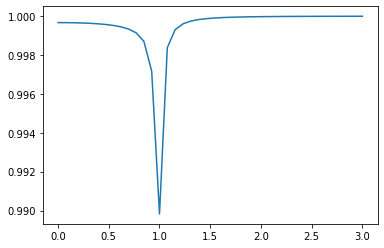

In [37]:
plt.plot(h_arr,abs(fd_arr))

In [14]:
abs(fd_arr)

array([0.        , 0.02564103, 0.05128205, 0.07692308, 0.1025641 ,
       0.12820513, 0.15384615, 0.17948718, 0.20512821, 0.23076923,
       0.25641026, 0.28205128, 0.30769231, 0.33333333, 0.35897436,
       0.38461538, 0.41025641, 0.43589744, 0.46153846, 0.48717949,
       0.51282051, 0.53846154, 0.56410256, 0.58974359, 0.61538462,
       0.64102564, 0.66666667, 0.69230769, 0.71794872, 0.74358974,
       0.76923077, 0.79487179, 0.82051282, 0.84615385, 0.87179487,
       0.8974359 , 0.92307692, 0.94871795, 0.97435897, 1.        ])

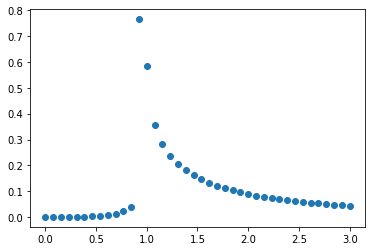

In [36]:
plt.scatter(h_arr,np.abs(ents_arr))

Text(0.5, 0.98, 'Infinite DMRG Phase Diagram')

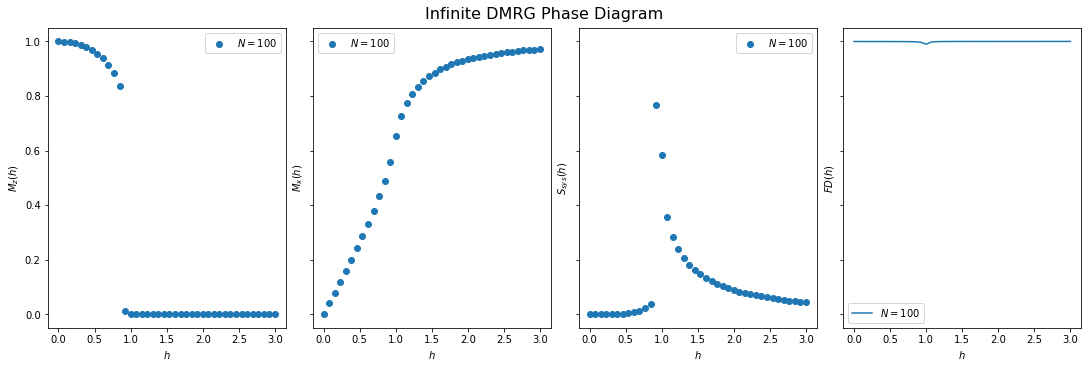

In [42]:
n = 100
fig, (fig_magz, fig_magx, fig_ent_s, fig_fd) = plt.subplots(1,4,figsize=(15, 5), constrained_layout=True, sharey=True)

fig_magz.scatter(h_arr,np.abs(magz_arr),label=r'$N= %d$'%n)
#fig_magz.set_title(r'M_(z)')
fig_magz.set_xlabel(r'$h$')
fig_magz.set_ylabel(r'$M_z(h)$')
fig_magz.legend()


fig_magx.scatter(h_arr,np.abs(magx_arr),label=r'$N= %d$'%n)
fig_magx.set_xlabel(r'$h$')
fig_magx.set_ylabel(r'$M_x(h)$')
#fig_magx.set_title('M_(x)')
fig_magx.legend()

fig_ent_s.scatter(h_arr,np.abs(ents_arr),label=r'$N= %d$'%n)
#fig_ent_s.scatter(h_arr,np.log(n*np.ones(disc_point)),label=r'$ln2$')
fig_ent_s.set_xlabel(r'$h$')
fig_ent_s.set_ylabel(r'$S_{sys}(h)$')
#fig_magx.set_title('M_(x)')
fig_ent_s.legend()

fig_fd.plot(h_arr,np.abs(fd_arr),label=r'$N= %d$'%n)
fig_fd.set_xlabel(r'$h$')
fig_fd.set_ylabel(r'$FD(h)$')
#fig_magx.set_title('M_(x)')
fig_fd.legend()

fig.suptitle('Infinite DMRG Phase Diagram', fontsize=16)
#plt.savefig('Infinite DMRG Phase Diagram N=%d.png'%n, dpi=300, bbox_inches='tight')

In [30]:
magz_arr

array([-9.67233461e-01, -1.44667536e-02, -8.53948848e-04, -1.27476146e-04,
       -3.05869407e-05, -9.81625509e-06, -3.84078377e-06, -1.73821473e-06,
       -8.81591759e-07, -4.91405234e-07, -2.97115812e-07, -1.92801269e-07,
       -1.32944025e-07, -9.64926950e-08, -7.30892753e-08, -5.73558432e-08,
       -4.63412442e-08, -3.83589964e-08, -3.23976824e-08, -2.78318708e-08,
       -2.42541862e-08, -2.13941997e-08, -1.90724996e-08, -1.71564091e-08,
       -1.55559738e-08, -1.42024266e-08, -1.30460615e-08, -1.20489015e-08,
       -1.11816223e-08, -1.04220948e-08, -9.75179987e-09, -9.15729363e-09,
       -8.62574408e-09, -8.14881479e-09, -7.71953696e-09, -7.32981976e-09,
       -6.97600746e-09, -6.65268134e-09, -6.35677838e-09, -6.08455737e-09])

In [11]:
def graphic(sys_block, env_block, sys_label="l",env_label="r"):
    """Returns a graphical representation of the DMRG step we are about to
    perform, using '=' to represent the system sites, '-' to represent the
    environment sites, and '**' to represent the two intermediate sites.
    """
    assert sys_label in ("l")
    assert env_label in ("r")
    graphic = ("=" * sys_block.length) + "**" + ("-" * env_block.length)
    return graphic

In [12]:
def finite_system_algorithm(J,h,L,d,m_warmup, m_sweep_list):
    assert L % 2 == 0  # require that L is an even number

    # To keep things simple, this dictionary is not actually saved to disk, but
    # we use it to represent persistent storage.
    sysblock_disk = {}  # "disk" storage for Block objects
    envblock_disk = {}
    # Use the infinite system algorithm to build up to desired size.  Each time
    # we construct a block, we save it for future reference as both a left
    # ("l") and right ("r") block, as the infinite system algorithm assumes the
    # environment is a mirror image of the system.
    H1 = h*Sx1 + d*Sz1
    Magz1 = Sz1
    Magx1 = Sx1
    initial_sysblock = SysBlock(length=1, basis_size=model_d, operator_dict={
        "H": H1,
        "Magz":Magz1,
        "Magx":Magx1,
        "conn_Sz": Sz1,
        "conn_Sx": Sx1,
        })
    initial_envblock = EnvBlock(length=1, basis_size=model_d, operator_dict={
        "H": H1,
        "Magz":Magz1,
        "Magx":Magx1,
        "conn_Sz": Sz1,
        "conn_Sx": Sx1,
        })
    sysblock = initial_sysblock
    envblock = initial_envblock
    sysblock_disk["l", sysblock.length] = sysblock
    envblock_disk["r", envblock.length] = envblock
    while 2 * sysblock.length < L:
        # Perform a single DMRG step and save the new Block to "disk"
        #print(graphic(sysblock, envblock))
        sysblock, envblock, energy, expect_magz, expect_magx, ent_s, psi0 = single_dmrg_step(J,h,d,sysblock, envblock, m=m_warmup)
        #print("E/L =", energy / (sysblock.length * 2))
        sysblock_disk["l", sysblock.length] = sysblock
        envblock_disk["r", envblock.length] = envblock

    # Now that the system is built up to its full size, we perform sweeps using
    # the finite system algorithm.  At first the left block will act as the
    # system, growing at the expense of the right block (the environment), but
    # once we come to the end of the chain these roles will be reversed.
    sys_label, env_label = "l", "r"
    sys_block = sysblock; del sysblock  # rename the sysvariable
    env_block = envblock; del envblock  # rename the envvariable
    for m in m_sweep_list:
        while True:
            # Load the appropriate environment block from "disk"
            env_block = envblock_disk[env_label, L - sys_block.length - 2]
            if env_block.length == 1:
                while True:
                # We've come to the end of the chain, so we reverse course.
#                 sys_block, env_block = env_block, sys_block
#                 sys_label, env_label = env_label, sys_label
                    sys_block = sysblock_disk[sys_label, L - env_block.length - 2]
                    env_block = envblock_disk[env_label, env_block.length]
                    #print(graphic(sys_block, env_block, sys_label),sys_block.length,env_block.length)
                    sys_block, env_block, energy, expect_magz, expect_magx,ent_s, psi0 = single_dmrg_step(J,h,d,sys_block, env_block, m=m)
                    #print("E/L =", energy / L)
                    #print("MAGZ/L =", expect_magz[0] / L)
                    #print("MAGX/L =", expect_magx[0] / L)
                    # Save the block from this step to disk.
                    envblock_disk[env_label, env_block.length] = env_block
                    # Check whether we just completed a full sweep.
                    if env_block.length == L - 2:
                        env_block = envblock_disk[env_label, env_block.length-2]
                        break  # escape from the "while True" loop
            ## Perform a single DMRG step.
            #print(graphic(sys_block, env_block),sys_block.length,env_block.length)
            sys_block, env_block, energy, expect_magz, expect_magx,ent_s, psi0 = single_dmrg_step(J,h,d,sys_block, env_block, m=m)
            #print("E/L =", energy / L)
            #print("MAGZ/L =", expect_magz[0] / L)
            #print("MAGX/L =", expect_magx[0] / L)
            # Save the block from this step to disk.
            sysblock_disk[sys_label, sys_block.length] = sys_block
            # Check whether we just completed a full sweep.
            if 2 * sys_block.length == L:
                break  # escape from the "while True" loop
    EXP_MAGZ = expect_magz[0] / L
    EXP_MAGX = expect_magx[0] / L
    return  energy, EXP_MAGZ,EXP_MAGX, ent_s, psi0
#if __name__ == "__main__":
    #np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

    #infinite_system_algorithm(L=100, m=20)
    #finite_system_algorithm(J=-1,h=-1,L=64, m_warmup=10, m_sweep_list=[10, 20, 30, 40, 40])

In [13]:
disc_point = 30
h_arr = np.linspace(0,2,disc_point)
magz_arr = np.linspace(0,2,disc_point)
magx_arr = np.linspace(0,2,disc_point)
fd_arr = np.linspace(0,2,disc_point)
ents_arr = np.linspace(0,2,disc_point)
for i in range(disc_point):
    energy, EXP_MAGZ,EXP_MAGX,ent_s, psi0 = finite_system_algorithm(J=-1,h=h_arr[i],d=1e-8,L=6, m_warmup=50, m_sweep_list=[50, 50])
    energy, EXP_MAGZ,EXP_MAGX,ent_ss, ppsi0 = finite_system_algorithm(J=-1,h=h_arr[i]+0.01,d=1e-8,L=6, m_warmup=50, m_sweep_list=[50, 50])
    magz_arr[i] =  EXP_MAGZ[0]
    magx_arr[i] =  EXP_MAGX[0]
    fd_arr[i] = csr_matrix.getH(psi0)@ppsi0
    ents_arr[i] = ent_s    
    print("Magz =", EXP_MAGZ[0])
    print("Magx =", EXP_MAGX[0])

Magz = -0.9999749981692029
Magx = -0.006666770788016428
Magz = -0.24091104815401043
Magx = -0.05269806839414204
Magz = -0.00578842557647589
Magx = -0.09903004201524389
Magz = -0.000590124681172625
Magx = -0.14613349151606597
Magz = -0.0001146125558187568
Magx = -0.19479971203337634
Magz = -3.2064603698829984e-05
Magx = -0.2461380562489914
Magz = -1.1363268557625558e-05
Magx = -0.3013702768547262
Magz = -4.757713390664738e-06
Magx = -0.3613353090360735
Magz = -2.25742325245711e-06
Magx = -0.42575271159583544
Magz = -1.1823702800358344e-06
Magx = -0.49264838876485273
Magz = -6.721964116995771e-07
Magx = -0.5586049179758364
Magz = -4.1016846772749343e-07
Magx = -0.6199848843976052
Magz = -2.6636987357497866e-07
Magx = -0.6742645916062114
Magz = -1.8274251400070737e-07
Magx = -0.7205287091344391
Magz = -1.3150203502972543e-07
Magx = -0.7591165796444539
Magz = -9.858657376571323e-08
Magx = -0.7910027490006204
Magz = -7.652522190463677e-08
Magx = -0.8173253485999313
Magz = -6.11694646046601e

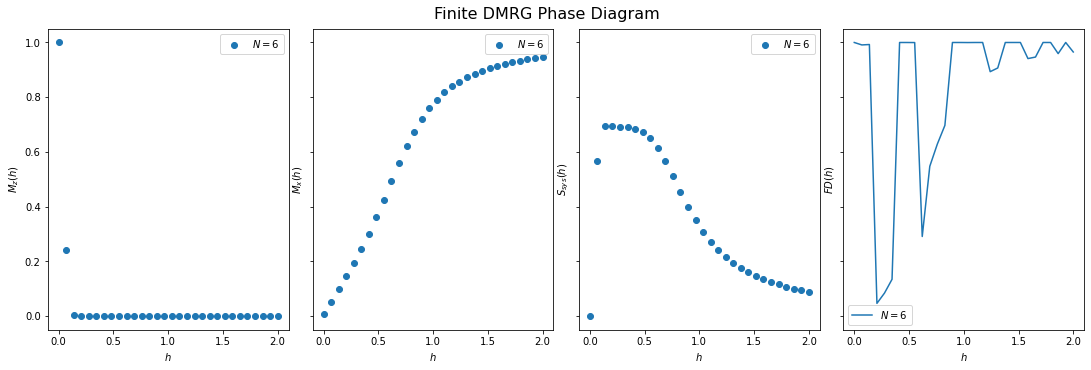

In [14]:
n = 6
fig, (fig_magz, fig_magx, fig_ent_s, fig_fd) = plt.subplots(1,4,figsize=(15, 5), constrained_layout=True, sharey=True)

fig_magz.scatter(h_arr,np.abs(magz_arr),label=r'$N= %d$'%n)
#fig_magz.set_title(r'M_(z)')
fig_magz.set_xlabel(r'$h$')
fig_magz.set_ylabel(r'$M_z(h)$')
fig_magz.legend()


fig_magx.scatter(h_arr,np.abs(magx_arr),label=r'$N= %d$'%n)
fig_magx.set_xlabel(r'$h$')
fig_magx.set_ylabel(r'$M_x(h)$')
#fig_magx.set_title('M_(x)')
fig_magx.legend()

fig_ent_s.scatter(h_arr,np.abs(ents_arr),label=r'$N= %d$'%n)
#fig_ent_s.scatter(h_arr,np.log(n*np.ones(disc_point)),label=r'$ln2$')
fig_ent_s.set_xlabel(r'$h$')
fig_ent_s.set_ylabel(r'$S_{sys}(h)$')
#fig_magx.set_title('M_(x)')
fig_ent_s.legend()

fig_fd.plot(h_arr,np.abs(fd_arr),label=r'$N= %d$'%n)
fig_fd.set_xlabel(r'$h$')
fig_fd.set_ylabel(r'$FD(h)$')
#fig_magx.set_title('M_(x)')
fig_fd.legend()

fig.suptitle('Finite DMRG Phase Diagram', fontsize=16)
plt.savefig('Finite DMRG Phase Diagram N=%d.png'%n, dpi=300, bbox_inches='tight')

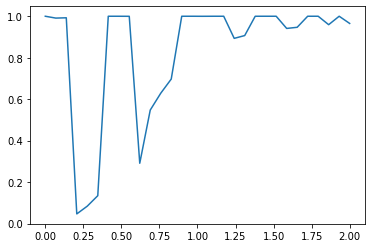

In [15]:
plt.plot(h_arr,abs(fd_arr))

In [ ]:
scatter(h_arr,np.abs(ents_arr),label=r'$N= %d$'%n)

In [78]:
a = np.array([[1],[2],[3],[4],[5],[6]])
re_a = a.reshape([3, -1], order="C") #sys = 3
re_b= a.reshape([2, -1], order="C") #sys=2


In [79]:
re_a

array([[1, 2],
       [3, 4],
       [5, 6]])

In [80]:
re_b

array([[1, 2, 3],
       [4, 5, 6]])

In [81]:
ua,sa,vha =svd(re_a,full_matrices=False)

In [82]:
ub,sb,vhb =svd(re_b,full_matrices=False)

In [83]:
ua

array([[-0.2298477 ,  0.88346102],
       [-0.52474482,  0.24078249],
       [-0.81964194, -0.40189603]])

In [84]:
sa

array([9.52551809, 0.51430058])

In [85]:
vha

array([[-0.61962948, -0.78489445],
       [-0.78489445,  0.61962948]])

In [86]:
ub

array([[-0.3863177 , -0.92236578],
       [-0.92236578,  0.3863177 ]])

In [87]:
sb

array([9.508032  , 0.77286964])

In [88]:
vhb

array([[-0.42866713, -0.56630692, -0.7039467 ],
       [ 0.80596391,  0.11238241, -0.58119908]])

In [45]:
sysblock.operator_dict[]

<30x30 sparse matrix of type '<class 'numpy.float64'>'
	with 558 stored elements in Compressed Sparse Row format>

In [76]:
new_sys_operator_dict = {}
for name, op in sysblock.operator_dict.items():
        new_sys_operator_dict[name] = op
        print(name)
#new_sys_operator_dict['ident_sys'] = new_sys_operator_dict['ident_sys']*3

H
Magz
Magx
conn_Sz
conn_Sx
ident_sys


In [77]:
sysblock.operator_dict.items()

dict_items([('H', <30x30 sparse matrix of type '<class 'numpy.float64'>'
	with 558 stored elements in Compressed Sparse Row format>), ('Magz', <30x30 sparse matrix of type '<class 'numpy.float64'>'
	with 480 stored elements in Compressed Sparse Row format>), ('Magx', <30x30 sparse matrix of type '<class 'numpy.float64'>'
	with 558 stored elements in Compressed Sparse Row format>), ('conn_Sz', <30x30 sparse matrix of type '<class 'numpy.float64'>'
	with 102 stored elements in Compressed Sparse Row format>), ('conn_Sx', <30x30 sparse matrix of type '<class 'numpy.float64'>'
	with 101 stored elements in Compressed Sparse Row format>), ('ident_sys', <30x30 sparse matrix of type '<class 'numpy.float64'>'
	with 102 stored elements in Compressed Sparse Row format>)])

In [80]:
name

'ident_sys'

In [78]:
new_sys_operator_dict[name].toarray()

array([[ 1.00000000e+00, -1.82877704e-17, -5.74867764e-19,
        -3.63467402e-22, -2.03491833e-20, -5.14892172e-22,
         1.69040962e-21, -2.34328823e-26,  4.34377265e-28,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.82877704e-17,  1.00000000e+00,  7.13944967e-17,
        -3.06568796e-18,  4.02403740e-19,  1.00142977e-20,
        -4.82042090e-20, -1.85001147e-22,  5.60061672e-24,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+

In [79]:
new_sys_operator_dict

{'H': <30x30 sparse matrix of type '<class 'numpy.float64'>'
 	with 558 stored elements in Compressed Sparse Row format>,
 'Magz': <30x30 sparse matrix of type '<class 'numpy.float64'>'
 	with 480 stored elements in Compressed Sparse Row format>,
 'Magx': <30x30 sparse matrix of type '<class 'numpy.float64'>'
 	with 558 stored elements in Compressed Sparse Row format>,
 'conn_Sz': <30x30 sparse matrix of type '<class 'numpy.float64'>'
 	with 102 stored elements in Compressed Sparse Row format>,
 'conn_Sx': <30x30 sparse matrix of type '<class 'numpy.float64'>'
 	with 101 stored elements in Compressed Sparse Row format>,
 'ident_sys': <30x30 sparse matrix of type '<class 'numpy.float64'>'
 	with 102 stored elements in Compressed Sparse Row format>}